In [72]:
# Created on jan 2025
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012692

# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd


# Empirical data

In [73]:
data_dir = './' # data repo
res_dir = './' # results

graph_format = 'png' # graph formatting


# data and model parameters
#subjects = [3, 4, 5, 6, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30]
subjects = [3, 4, 5, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30]
n_sub = 48
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90


In [74]:
pwd

'/home/angelica/Desktop/EntropyProduction_MOUProcess'

In [75]:
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')



In [76]:
condition_0 = TS_CTR[:, 0:68, :] 
condition_0.shape 

(116, 68, 152)

In [77]:

# Example input array of shape (180, 718, 36)
#original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array.shape)

New array shape: (48, 68, 152, 2)


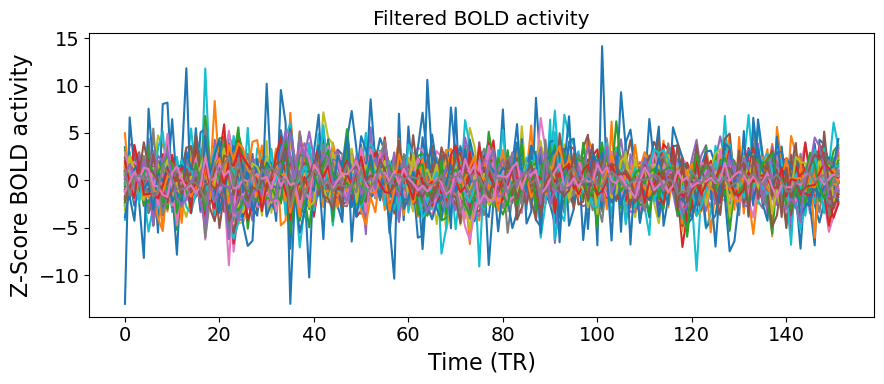

In [78]:
#All data plotted are stored in new_array
plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

Text(0.5, 1.0, 'FC0')

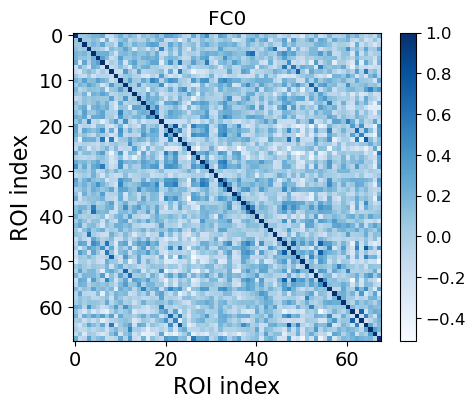

In [79]:
FC0 = np.corrcoef(new_array[1,:,:,1]) 
FC1 = FC0/np.max(FC0)
plt.figure(figsize=(5,4))
plt.imshow(FC1, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC0")

# Functional Mask

In [80]:
# create topological mask for AAL90
N=68
FC0 = np.corrcoef(new_array[44,:,:,1]) 
FC1 = FC0/np.max(FC0)
lim_FC = 0.1 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[FC1>lim_FC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


network size: 68
EC density: 0.36259877085162423


## Connectome mask

In [81]:
# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.2 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0



network size: 68
EC density: 0.31562774363476737


In [82]:
SC = sio.loadmat('./SC_EnigmadK68.mat')

In [83]:
SC = sio.loadmat('./SC_EnigmadK68.mat')['matrix']

In [84]:
#to get folder path
pwd


NameError: name 'pwd' is not defined

## Something wrong with the data I'm using

## Functional data

Parameters, they will be loaded later

In [ ]:
# BOLD broadband filtering#Change
n_order = 3
TR = 2.0 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.01 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.2 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

# lags (in TR): 0 and 1
v_lag = np.arange(2,dtype=float)
n_lag = v_lag.size

# calc example FC for single subj
ts = sio.loadmat(data_dir+'ts_Sleep_198_AAL.mat')['ts_'+conds[0]][0,0] #WHAT SHOULD I PUT HERE
filt_ts = spsg.filtfilt(b,a,ts,axis=1)
FC0 = np.tensordot(filt_ts[:,:-1], filt_ts[:,:-1], axes=(1,1)) / filt_ts.shape[1]-1
FC1 = np.tensordot(filt_ts[:,:-1], filt_ts[:,1:], axes=(1,1)) / filt_ts.shape[1]-1


## Visual test of data 

In particular for order of ROIs for 2 hemispheres...

ValueError: x and y must have same first dimension, but have shapes (152,) and (116, 152, 82)

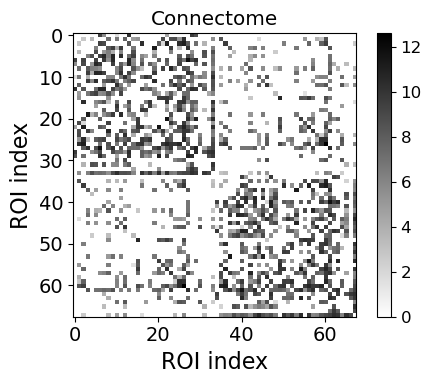

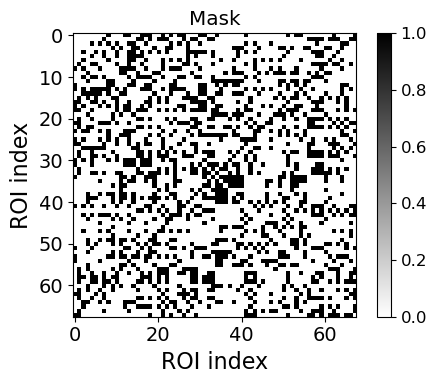

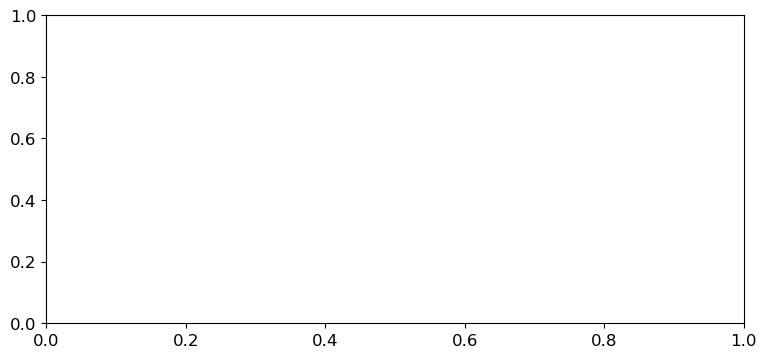

In [ ]:
plt.figure(figsize=(5,4))
plt.imshow(np.array(SC, dtype=float), cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("Connectome")
plt.tight_layout()
plt.savefig(res_dir+'SC.eps', format='eps')

plt.figure(figsize=(5,4))
#plt.imshow(np.array(mask_EC, dtype=float), cmap='binary')
plt.imshow(mask_EC, cmap='binary')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("Mask")
plt.tight_layout()
plt.savefig(res_dir+'mask_EC.eps', format='eps')

plt.figure(figsize=(9,4))
plt.plot(range(filt_ts.shape[1]), filt_ts.T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()
plt.savefig(res_dir+'example_ts.eps', format='eps')

plt.figure(figsize=(5,4))
plt.imshow(FC0, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC0")
plt.tight_layout()
plt.savefig(res_dir+'example_FC0.eps', format='eps')

plt.figure(figsize=(5,4))
plt.imshow(FC1, cmap='Greens', vmin=0)
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC1")
plt.tight_layout()
plt.savefig(res_dir+'example_FC1.eps', format='eps')
    

# MOU fitting to fMRI data

In [85]:
#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=48
n_cond=2
N=68
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        lim_FC = 0.1 # limit DTI value to determine SC (only connections with larger values are tuned)
        mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC[FC1>lim_FC] = True
        for i in range(N):
            mask_EC[i,i] = False # no self connection
            mask_EC[i,N-1-i] = True # additional interhemispherical connections
 
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)



sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 95, 'distance': np.float64(0.7661432834911104), 'correlation': np.float64(0.735406777537547), 'distance history': array([0.91027644, 0.90788178, 0.90552969, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.42523869, 0.43323628, 0.44106712, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7248400507908922), 'distFC1': np.float64(0.8075789347682952)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 35, 'distance': np.float64(0.8114780800589657), 'correlation': np.float64(0.6566428382782753), 'distance history': array([0.89350402, 0.88902935, 0.88523676, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.40505704, 0.43514997, 0.4621871 , ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.6990544107283141), 'distFC1': np.float64(0.9242423689314986)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 70, 'distance': np.float64(0.8183950522320937), '

In [86]:
#%% save results
np.save(res_dir+'J_mod.npy',J_mod)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod)
np.save(res_dir+'FC0_mod.npy',FC0_mod)

np.save(res_dir+'err_mod.npy',err_mod)
np.save(res_dir+'fit_mod.npy',fit_mod)

np.save(res_dir+'var_BOLD.npy',var_BOLD)


## Test goodness of fit

/tmp/ipykernel_21462/723428449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_21462/723428449.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_21462/723428449.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_21462/723428449.py:38: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


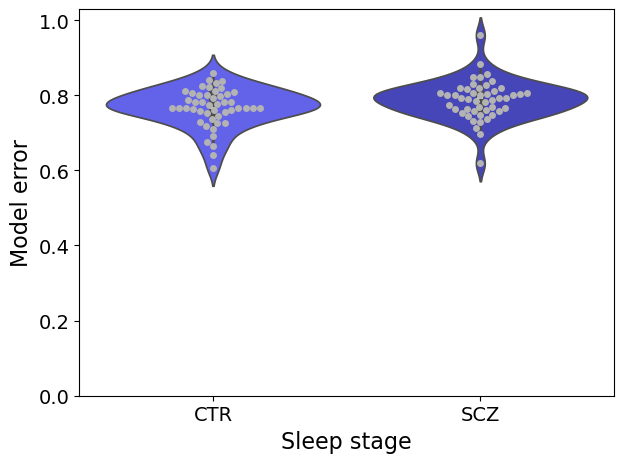

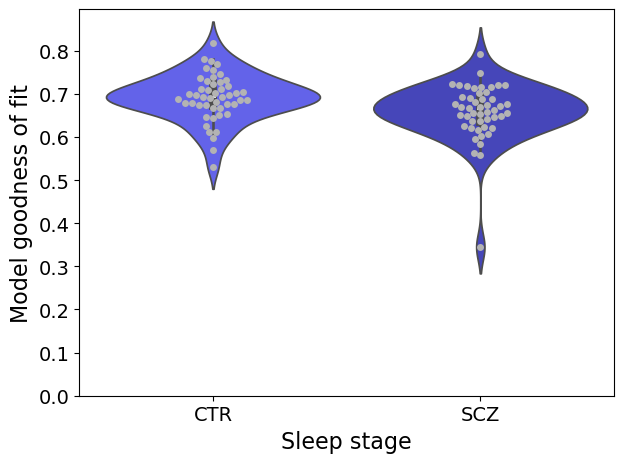

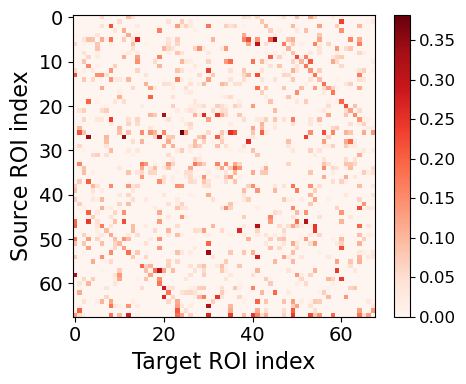

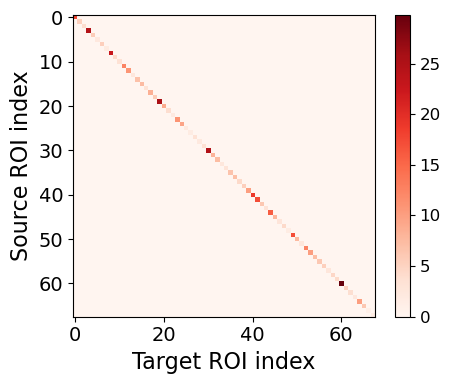

In [87]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_fit_error.eps', format='eps')


# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

## I think I do not need this part: 

In [88]:
fit_mod_df
COND= fit_mod_df["cond"]

In [89]:
OAW=fit_mod_df[COND == 'W']
ON1=fit_mod_df[COND == 'N1']
ON2=fit_mod_df[COND == 'N2']
ON3=fit_mod_df[COND == 'N3']
A=ON1[ON1["sum EC"] > 0.43]
XAW=OAW["sum EC"]
XN1=A["sum EC"]
XN2=ON2["sum EC"]
XN3=ON3["sum EC"]

In [90]:
ST=EPR_df["sleep stage"]
EPAW=EPR_df[ST=='W']
EPN1=EPR_df[ST=='N1']
EPN2=EPR_df[ST=='N2']
EPN3=EPR_df[ST=='N3']
A=EPN1[EPN1["EPR"] < 4]
YAW=EPAW["EPR"]
YN1=A["EPR"]
YN2=EPN2["EPR"]
YN3=EPN3["EPR"]
from scipy.stats.stats import pearsonr 
from scipy.stats.stats import spearmanr

print(spearmanr(XAW,YAW))



print(pearsonr(XAW,YAW)[0],pearsonr(XN1,YN1)[0],pearsonr(XN2,YN2)[0],pearsonr(XN3,YN3)[0])
print(pearsonr(XAW,YAW)[1],pearsonr(XN1,YN1)[1],pearsonr(XN2,YN2)[1],pearsonr(XN3,YN3)[1])
#print(np.corrcoef(XAW,YAW)[1,0],np.corrcoef(XN1,YN1)[1,0],np.corrcoef(XN2,YN2)[1,0],np.corrcoef(XN3,YN3)[1,0])

print(spearmanr(XAW,YAW)[0],spearmanr(XN1,YN1)[0],spearmanr(XN2,YN2)[0],spearmanr(XN3,YN3)[0])
print(spearmanr(XAW,YAW)[1],spearmanr(XN1,YN1)[1],spearmanr(XN2,YN2)[1],spearmanr(XN3,YN3)[1])


SignificanceResult(statistic=nan, pvalue=nan)


/tmp/ipykernel_21462/2298717277.py:11: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr
/tmp/ipykernel_21462/2298717277.py:12: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import spearmanr


ValueError: `x` and `y` must have length at least 2.

In [ ]:
YAW

In [ ]:
SEC=fit_mod_df["sum EC"]
EPRV=EPR_df["EPR"]
EPR_df['SEC'] = SEC
EPRVSO=EPR_df[EPR_df["EPR"] < 4]
EPRVSO

In [ ]:
print(spearmanr(EPRVSO["SEC"],EPRVSO["EPR"]))

In [ ]:
#plt.scatter(SEC, EPRV,alpha=0.5)
plt.scatter(EPRVSO["SEC"], EPRVSO["EPR"],alpha=0.5)

In [ ]:
plt.scatter(XAW, YAW,alpha=0.5)
plt.xlabel('Goodness of fit') 
plt.ylabel('Entropy Production') 
plt.title("Awake")
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(2, 2,figsize=(10, 10))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
axs[0, 0].scatter(XAW, YAW,alpha=0.7)
axs[0, 0].set_title("Awake")
axs[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#axs[0, 0].text(0.55, 3.1, 'r=-0.646, p=0.009')
axs[0, 0].text(0.55, 3.1, 's=-0.582, p=0.023')
axs[0, 1].scatter(XN1, YN1,alpha=0.7)
axs[0, 1].set_title("N1")
axs[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#axs[0, 1].text(0.65, 2.55, 'r=-0.299, p=0.3')
axs[0, 1].text(0.65, 2.55, 's=-0.319, p=0.267')
axs[1, 0].scatter(XN2, YN2,alpha=0.7)
axs[1, 0].set_title("N2") 
axs[1, 0].text(0.71, 1.95, 's=-0.489, p=0.0641')
#axs[1, 0].text(0.71, 1.9, 's=-0.489, p=0.0641')
axs[1, 1].scatter(XN3, YN3,alpha=0.7)
axs[1, 1].set_title("N3")
axs[1, 1].text(0.74, 1.82, 's=-0.107, p=0.704')
#axs[1, 1].text(0.74, 1.74, 's=-0.107, p=0.704')

#-0.5821428571428571 -0.3186813186813187 -0.4892857142857142 -0.10714285714285714
#0.022793687126414258 0.2667849608113615 0.06416038631454055 0.7039010016261615
#plt.xlabel('Goodness of fit') 
#plt.ylabel('Entropy Production') 
#axs.set_xlabel('common xlabel')
#axs.set_ylabel('common ylabel')
# Adding a plot in the figure which will encapsulate all the subplots with axis showing only
fig.add_subplot(1, 1, 1, frame_on=False)

# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)

# Adding the x-axis and y-axis labels for the bigger plot
plt.xlabel('Goodness of Fit', fontsize=12, fontweight='bold')
plt.ylabel('Entropy Production', fontsize=12, fontweight='bold')
plt.savefig("gofvsep2.jpg", dpi=150)


# labels of sleep sessions for classification

In [ ]:
# labels of sleep sessions for classification
group_labels = np.repeat(np.arange(n_cond).reshape([1,n_cond]), n_sub, axis=0)
# 0 Awake
# 1 N1
# 2 N3
# 3 N3


# Features (inputs to classifiers)

In [ ]:
# create features (inputs to classifiers)

# model Jacobian
mask_EC = np.load(res_dir+'mask_EC.npy')
vect_EC = J_mod[:,:,mask_EC] #shape patients,conditions,number of positives in the mask (15, 4, 2484)


# model input covariances
vect_Sigma = Sigma_mod[:,:,mask_Sigma]

# model covariances
mask_tri = np.tri(N,N,-1,dtype=bool)
vect_corrFC = np.zeros(FC0_mod.shape)
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        vect_corrFC[i_sub,i_cond,:,:] = FC0_mod[i_sub,i_cond,:,:] 
        vect_corrFC[i_sub,i_cond,:,:] /= np.sqrt(np.outer(FC0_mod[i_sub,i_cond,:,:].diagonal(),FC0_mod[i_sub,i_cond,:,:].diagonal()))
vect_corrFC = vect_corrFC[:,:,mask_tri]

vect_features = [vect_EC, vect_Sigma, vect_corrFC]
n_vect_features = len(vect_features)


In [ ]:
# classifiers and learning parameters
c_MLR = skppl.make_pipeline(skppr.StandardScaler(), skllm.LogisticRegression(C=1.0, penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=500))
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric = 'correlation')

classifiers = [c_MLR, c_1NN]
n_classifiers = len(classifiers)

In [ ]:
# number of repetition of classification procedure
n_rep = 100

# record classification performance
perf = np.zeros([n_rep,n_vect_features,n_classifiers])
perf_shuf = np.zeros([n_rep,n_vect_features,n_classifiers]) # surrogate classification performance by shuffling labels as chance level


#%% perform classification
for i_rep in range(n_rep):
    print('cross-val split', i_rep)
    
    # train and test classifiers to discriminate sessions
    # split subjects for train and test sets (80% and 20%, respectively)
    train_ind = np.ones([n_sub,n_cond],dtype=bool)
    while train_ind.sum()>0.8*n_sub*n_cond:
        train_ind[np.random.randint(n_sub),:] = False
    test_ind = np.logical_not(train_ind)

    # surrogates (stratified for train/test sets)
    group_labels_shuf = np.copy(group_labels)
    group_labels_shuf[train_ind] = np.random.permutation(group_labels_shuf[train_ind])
    group_labels_shuf[test_ind] = np.random.permutation(group_labels_shuf[test_ind])
    
    for i_f in range(n_vect_features): # C, sigma, corr
        for i_c in range(n_classifiers):  # MLR and 1NN
            classifiers[i_c].fit(vect_features[i_f][train_ind,:], group_labels[train_ind])
            perf[i_rep,i_f,i_c] = classifiers[i_c].score(vect_features[i_f][test_ind,:], group_labels[test_ind])

            classifiers[i_c].fit(vect_features[i_f][train_ind,:], group_labels_shuf[train_ind])
            perf_shuf[i_rep,i_f,i_c] = classifiers[i_c].score(vect_features[i_f][test_ind,:], group_labels_shuf[test_ind])

np.save(res_dir+'perf.npy', perf)
np.save(res_dir+'perf_shuf.npy', perf_shuf)

## plot the performance

In [ ]:
cols = [[0.8,0.2,0.2],[0.6,0.2,0.6],[0.2,0.2,0.8]] # colors

# MLR classifier

fc = ['$C$','$D$','$\hat{S}$']

perf_tmp = dict()
perf_tmp['perf'] = perf[:,:,0].flatten()
perf_tmp['perf shuf'] = perf_shuf[:,:,0].flatten()
perf_tmp['feat+clf'] = np.repeat(np.array(fc, dtype=str).reshape([-1,3]), n_rep, axis=0).flatten()

perf_df = pd.DataFrame(perf_tmp)

plt.figure()
ax = sb.violinplot(data=perf_df, x='feat+clf', y='perf shuf', color=[0.7,0.7,0.7]) #1/4 in average as pure chance
sb.violinplot(data=perf_df, x='feat+clf', y='perf', palette=cols)
#sb.swarmplot(data=perf_df, x='feat+clf', y='perf', color=[0.7,0.7,0.7])
plt.plot([-0.5,2.5],[1.0/n_cond]*2,'--k')
plt.axis(xmin=-0.5,xmax=2.5,ymin=0.0,ymax=1.05)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Accuracy',fontsize=16)
plt.title("MLR Classifier")
plt.tight_layout()
plt.savefig(res_dir+'classif_perf_MLR.eps', format='eps')




In [ ]:
perf_df

In [ ]:
# 1NN classifier
cols = [[0.8,0.2,0.2],[0.6,0.2,0.6],[0.2,0.2,0.8]] # colors
fc = ['$C$','$D$','$\hat{S}$']

perf_tmp = dict()
perf_tmp['perf'] = perf[:,:,1].flatten()
perf_tmp['perf shuf'] = perf_shuf[:,:,1].flatten()
perf_tmp['feat+clf'] = np.repeat(np.array(fc, dtype=str).reshape([-1,3]), n_rep, axis=0).flatten()

perf_df = pd.DataFrame(perf_tmp)

plt.figure()
ax = sb.violinplot(data=perf_df, x='feat+clf', y='perf shuf', color=[0.7,0.7,0.7]) #1/4 in average as pure chance
sb.violinplot(data=perf_df, x='feat+clf', y='perf', palette=cols)
#sb.swarmplot(data=perf_df, x='feat+clf', y='perf', color=[0.7,0.7,0.7])
plt.plot([-0.5,2.5],[1.0/n_cond]*2,'--k')
plt.axis(xmin=-0.5,xmax=2.5,ymin=0.0,ymax=1.05)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Accuracy',fontsize=16)
plt.title("1NN Classifier")
plt.tight_layout()
plt.savefig(res_dir+'classif_perf_1NN.eps', format='eps')



# Calculate Entropy Production of the fitted MOU

In [91]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(res_dir+'EPR.npy',EPR)



should be close to zero: 1.1013412404281553e-13
should be close to zero: 1.0658141036401503e-13
should be close to zero: 1.1368683772161603e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 2.7000623958883807e-13
should be close to zero: 1.4921397450962104e-13
should be close to zero: 7.105427357601002e-14
should be close to zero: 2.2737367544323206e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 4.8031023602845835e-14
should be close to zero: 2.3447910280083306e-13
should be close to zero: 3.552713678800501e-13
should be close to zero: 3.268496584496461e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 1.3677947663381929e-13
should be close to zero: 6.142308883738679e-14
should be close to zero: 3.979039320256561e-13
should be close to zero: 3.694822225952521e-13
should be close to zero: 5.5067062021407764e-14
should be close to zero: 2.2294666113253925e-13
should be close to zero: 1.4210854715202004e-1

/tmp/ipykernel_21462/2244750152.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_21462/2244750152.py:22: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


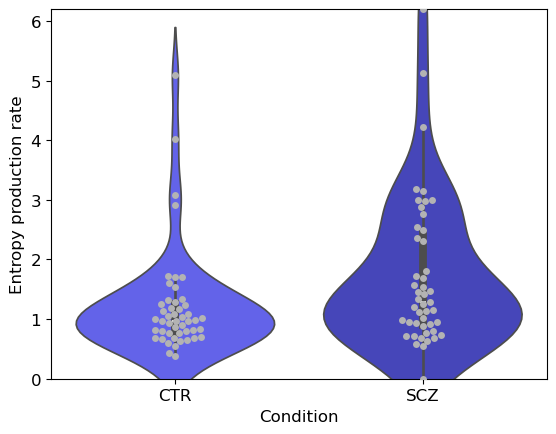

In [92]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

EPR_df=EPR_df.drop(index=13)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=6.2)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [93]:
EPR_df

,sleep stage,EPR
0,CTR,0.772211
1,SCZ,3.001147
2,CTR,0.962673
3,SCZ,2.767040
4,CTR,3.089407
...,...,...
91,SCZ,0.935239
92,CTR,0.680526
93,SCZ,1.137500
94,CTR,1.541567


In [94]:
ctv=EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist()
stv=EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
len(stv)



47

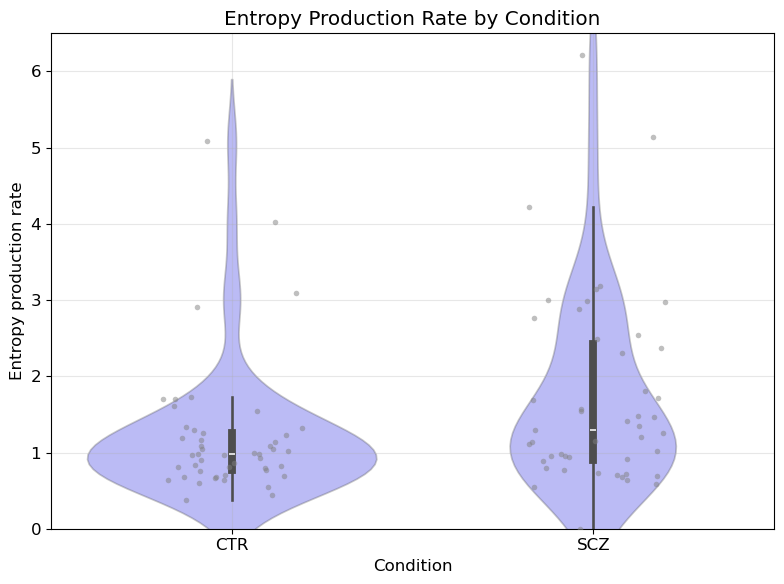

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Create the figure
plt.figure(figsize=(8, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 6.5)
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

plt.show()

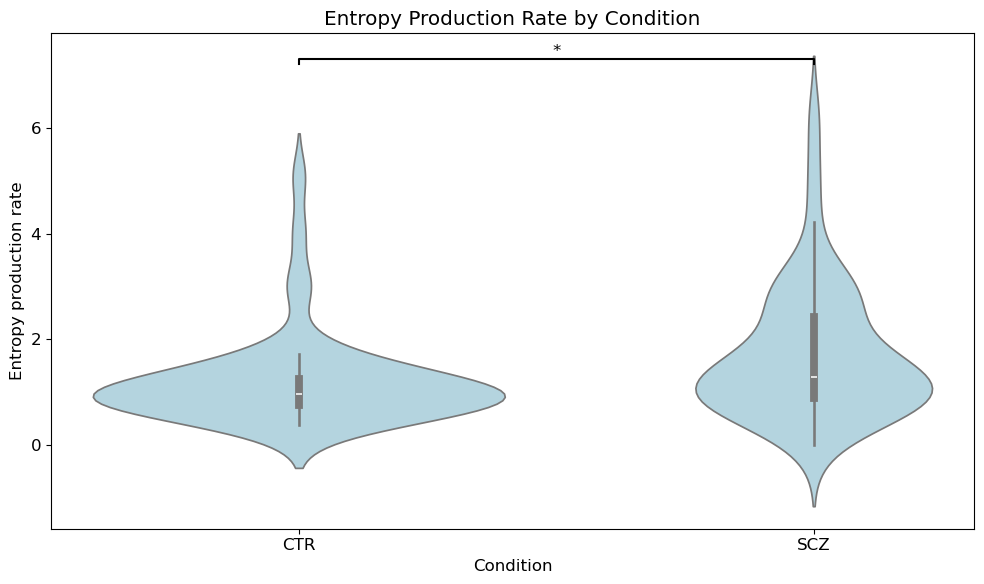

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Assuming your data is stored in a DataFrame called 'df' with columns 'Condition' and 'Entropy_production_rate'
# If not, adjust the code accordingly

data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

def add_significance_bar(ax, data, x1, x2, y, h, p_value):
    """
    Add significance bar to the plot
    
    Parameters:
    -----------
    ax : matplotlib axes object
    data : pandas DataFrame
    x1, x2 : str
        Names of conditions to compare
    y : float
        Height at which to draw the bar
    h : float
        Height of the vertical lines
    p_value : float
        P-value to determine number of asterisks
    """
    # Convert p-value to significance stars
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    # Get x coordinates
    x1_coord = 0  # Position for 'CTR'
    x2_coord = 1  # Position for 'SCZ'
    
    # Plot the bar
    ax.plot([x1_coord, x1_coord, x2_coord, x2_coord], [y, y+h, y+h, y], 'k-', linewidth=1.5)
    
    # Add star annotation
    ax.text((x1_coord + x2_coord) * 0.5, y+h, star_string,
            ha='center', va='bottom', fontsize=12)

# Example usage:
# First create your violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Condition', y='Entropy_production_rate', data=data,
                    inner='box', color='lightblue')

# Perform statistical test

ctr_data = EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'] 
scz_data = EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR']
stat, p_value = stats.mannwhitneyu(ctr_data, scz_data)

# Add significance bar
# Set y and h based on your data's range
max_val = scz_data.max()
y = max_val + 1  # Adjust these values based on your plot
h = 0.1
add_significance_bar(ax, data, 'CTR', 'SCZ', y, h, p_value)

# Customize plot
plt.title('Entropy Production Rate by Condition')
plt.ylabel('Entropy production rate')
plt.tight_layout()

# Show plot
plt.show()

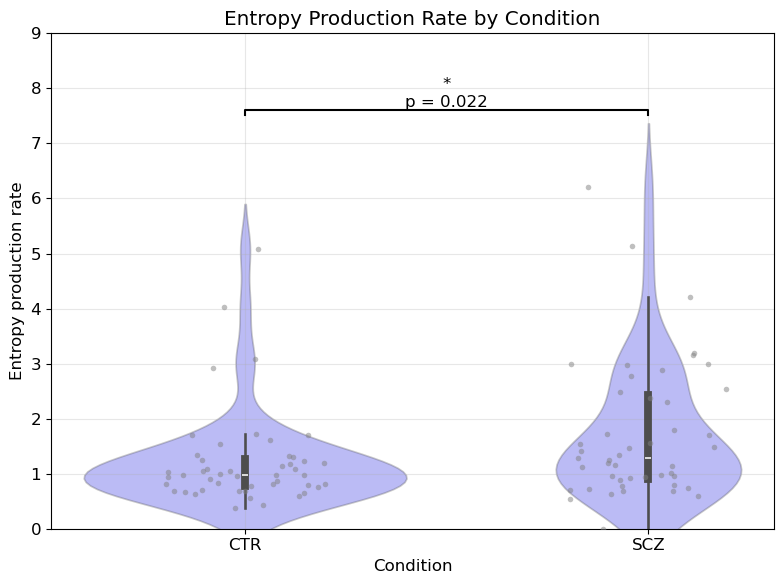


Statistical Test Results:
Mann-Whitney U test statistic: 819.00
p-value: 0.022


In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(8, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def add_stat_annotation(p_value):
    # Define the significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    # Get y coordinates for the bar
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 1.3
    
    # Plot the significance bar
    x1, x2 = 0, 1  # x-coordinates for CTR and SCZ
    bar_height_diff = 0.1
    
    plt.plot([x1, x1, x2, x2], 
            [bar_height, bar_height + bar_height_diff, bar_height + bar_height_diff, bar_height],
            'k-', linewidth=1.5)
    
    # Add star annotation
    plt.text((x1 + x2) * 0.5, bar_height + bar_height_diff,
            f'{star_string}\np = {p_value:.3f}',
            ha='center', va='bottom')

# Add the significance annotation
add_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')

/tmp/ipykernel_21462/1476152158.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


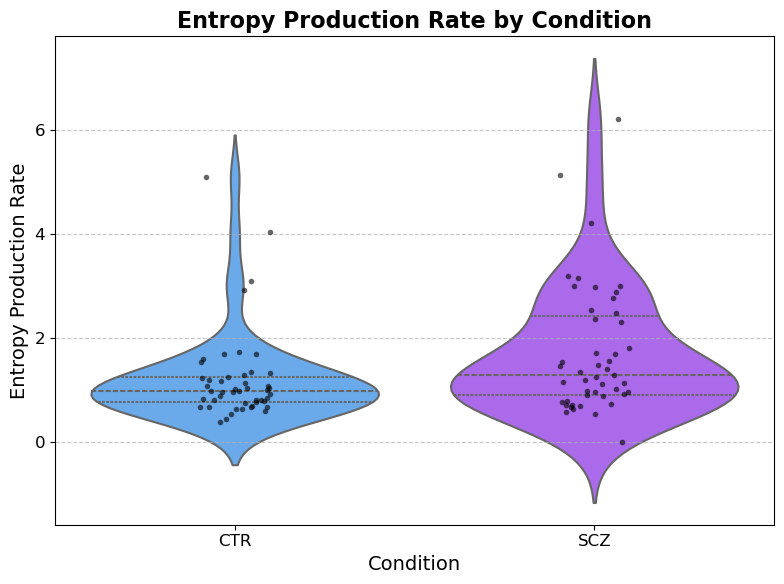

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data

data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})



# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Condition",
    y="Entropy_production_rate",
    data=data,
    palette="cool",
    inner="quartile",
    linewidth=1.5
)

# Add individual data points
sns.stripplot(
    x="Condition",
    y="Entropy_production_rate",
    data=data,
    color="black",
    size=4,
    alpha=0.6,
    jitter=True
)

# Customize the plot
plt.title("Entropy Production Rate by Condition", fontsize=16, fontweight="bold")
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Entropy Production Rate", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [65]:
np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

array(['CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR',
       'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ',
       'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR',
       'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ',
       'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR',
       'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ',
       'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR',
       'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ',
       'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR',
       'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ',
       'CTR', 'SCZ', 'CTR', 'SCZ', 'CTR', 'SCZ'], dtype='<U3')

In [66]:
np.repeat(np.array(conds, dtype=str), n_sub, axis=0).flatten()

array(['CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR',
       'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR',
       'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR',
       'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR',
       'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR', 'CTR',
       'CTR', 'CTR', 'CTR', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ',
       'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ',
       'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ',
       'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ',
       'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ',
       'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ', 'SCZ'], dtype='<U3')

In [67]:
EPR_df

,sleep stage,EPR
0,CTR,0.772211
1,SCZ,3.001147
2,CTR,0.962673
3,SCZ,2.767040
4,CTR,3.089407
...,...,...
91,SCZ,0.935239
92,CTR,0.680526
93,SCZ,1.137500
94,CTR,1.541567


In [68]:
import os

import scipy.io as sio
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))


Files in '/home/angelica/Desktop/EntropyProduction_MOUProcess': ['SC.eps', 'ts_scz.mat', 'TS_Schizo.npy', 'resultsSC.eps', '2801_CalcEntropyMOU-SCZ.ipynb', 'resultserr_mod.npy', 'masks_FC0_comparison.ipynb', '._CalcEntropyMOU-Humans-SCZ.ipynb', 'resultsmodel_goodness_fit.eps', 'EPR.npy', 'resultsmask_EC.eps', 'model_goodness_fit.eps', '._ts_scz.mat', 'ENIGMA', 'masks_low.ipynb', 'masks_FC0_30.ipynb', 'CalcEntropyMOU-Humans-SCZ.ipynb', 'EPR_MOU_base.ipynb', 'masks_or.ipynb', 'masks_FC0.ipynb', '__pycache__', '._ts_ctr.mat', 'err_mod.npy', 'masks_connectome.ipynb', 'masks_and.ipynb', 'masks_FC0_70.ipynb', 'FC0_mod.npy', 'example_EC.eps', 'masks_FC0_50.ipynb', 'resultsvar_BOLD.npy', 'entropy_prod_rate.eps', 'fit_mod.npy', 'masks_FC0_80.ipynb', 'results', 'model_fit_error.eps', 'masks_FC0_40.ipynb', 'resultsSigma_mod.npy', 'resultsFC0_mod.npy', 'masks_comparison.ipynb', 'Sigma_mod.npy', 'J_mod.npy', 'TS_Control.npy', 'mask_EC.eps', 'SC_EnigmadK68.mat', 'resultsEPR.npy', 'resultsentropy_pro

In [99]:
#%% load model estimates

res_dir = './' 
#res_dir = 'model_sleep_noSC/'
#res_dir = 'model_sleep_ccovSigma/'

# Jacobian
J = np.load(res_dir+'J_mod.npy')
mask_EC = np.load(res_dir+'mask_EC.npy')
# input covariances
Sigma = np.load(res_dir+'Sigma_mod.npy')
mask_Sigma = np.load(res_dir+'mask_Sigma.npy')
# model covariances
FC0 = np.load(res_dir+'FC0_mod.npy')

FileNotFoundError: [Errno 2] No such file or directory: './mask_EC.npy'

In [ ]:
#%% transpose to Saclay's framework

subjects = [3, 4, 5, 6, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30]
#subjects = [3, 4, 5, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30] # REMOVE SUBJ 6

ind_sub = np.arange(len(subjects))
ind_sub = np.delete(ind_sub, 3)
n_sub = ind_sub.size

N = J.shape[2]

J = J[ind_sub,:,:]
Sigma = Sigma[ind_sub,:,:]
FC0 = FC0[ind_sub,:,:]

conds = ['W', 'N1', 'N2', 'N3']
n_cond = len(conds) # W, N1, N2, N3


In [ ]:
#%%

ROI_labels_tmp = np.genfromtxt('/Users/rodrigocofre/Desktop/Postdoc-Codes/model_sleep/EPnotebook/nodos_compare_AAL_DECO.csv', delimiter=';', dtype=str)
ROI_labels_tmp = ROI_labels_tmp[:,1]
for i in range(N):
    ROI_labels_tmp[i] = ROI_labels_tmp[i][:-1]
ROI_labels = np.copy(ROI_labels_tmp)
for i in range(int(N/2)):
    ROI_labels[i] = ROI_labels_tmp[2*i].replace('_',' ')
    ROI_labels[N-1-i] = ROI_labels_tmp[2*i+1].replace('_',' ')

In [ ]:
n_shuf = 3
EPR_shuf_EC = np.zeros([n_sub,n_cond,n_shuf])
EPR_shuf_Sg = np.zeros([n_sub,n_cond,n_shuf])
            
for i_shuf in range(n_shuf):
    shuf_cond = np.roll(np.arange(n_cond), i_shuf+1)
    shuf_ind = np.repeat(shuf_cond.reshape([1,n_cond]), n_sub, axis=0)
        
    for i_sub in range(n_sub):
        for i_cond in range(n_cond):
            # surrogates
            i_cond_shuf = shuf_ind[i_sub,i_cond]
            
            # surrogates EC
            B = -J[i_sub,i_cond_shuf,:,:].T
            D = 0.5 * Sigma[i_sub,i_cond,:,:]
            S = spl.solve_continuous_lyapunov(-B, -2*D)
            
            Q = np.dot(B, S) - D
            
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate_shuf = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))

            EPR_shuf_EC[i_sub,i_cond,i_shuf] = entropy_prod_rate_shuf - EPR[i_sub,i_cond]
            
            # surrogates Sigma
            B = -J[i_sub,i_cond,:,:].T
            D = 0.5 * Sigma[i_sub,i_cond_shuf,:,:]
            S = spl.solve_continuous_lyapunov(-B, -2*D)
            
            Q = np.dot(B, S) - D
            
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate_shuf = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))

            EPR_shuf_Sg[i_sub,i_cond,i_shuf] = entropy_prod_rate_shuf - EPR[i_sub,i_cond]



np.save(res_dir+'EPR.npy',EPR)
np.save(res_dir+'EPR_shuf_EC.npy',EPR_shuf_EC)
np.save(res_dir+'EPR_shuf_Sg.npy',EPR_shuf_Sg)            


In [ ]:
#%% plots



if False:
    EPR = np.load(res_dir+'EPR.npy')
    EPR_shuf_EC = np.load(res_dir+'EPR_shuf_EC.npy')
    EPR_shuf_Sg = np.load(res_dir+'EPR_shuf_Sg.npy')


matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
#cols2 = [[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5],[0.4,0.4,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

EPR_tmp = dict()
conds_shuf = np.zeros([n_sub,n_cond,n_shuf], dtype='<U2')
for i_cond in range(n_cond):
    for i_sub in range(n_sub):
        for i_shuf in range(n_shuf):
            conds_shuf[i_sub,i_cond,i_shuf] = conds[i_cond]
EPR_tmp['sleep stage'] = conds_shuf.flatten()
EPR_tmp['EPR shuf EC'] = EPR_shuf_EC.flatten()
EPR_tmp['EPR shuf Sg'] = EPR_shuf_Sg.flatten()

EPR_shuf_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=5)

x1, x2 = 0, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 4.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = 0, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 4.6, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

plt.xlabel('Sleep stage', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')


plt.figure()
plt.subplot(211)
for i_cond in range(n_cond):
    Q_in_tmp = np.abs(Q_indiv[:,i_cond,:,:]).sum(2)
    plt.errorbar(range(N), Q_in_tmp.mean(0), yerr=Q_in_tmp.std(0)/np.sqrt(n_sub), c=cols[i_cond])
#plt.axis(ymin=0, ymax=5)
plt.subplot(212)
for i_cond in range(n_cond):
    Q_out_tmp = np.abs(Q_indiv[:,i_cond,:,:]).sum(1)
    plt.errorbar(range(N), Q_out_tmp.mean(0), yerr=Q_out_tmp.std(0)/np.sqrt(n_sub), c=cols[i_cond])
#plt.axis(ymin=0, ymax=5)
plt.xticks(range(N), ROI_labels, rotation=90, fontsize=9)
plt.yticks(fontsize=12)
plt.xlabel('ROI index', fontsize=12)


ROI_labels_symm = np.copy(ROI_labels[:int(N/2)])
for i in range(int(N/2)):
    ROI_labels_symm[i] = ROI_labels_symm[i][:-2]
plt.figure()
#for i_cond in range(n_cond):
for i_cond in [0,3]:
    Q_av = np.zeros([n_sub,int(N/2)])
    Q_in_tmp = np.abs(Q_indiv[:,i_cond,:,:]).sum(2) # Q antisymm
    for i in range(int(N/2)):
        Q_av[:,i] = np.abs(Q_in_tmp[:,i]) + np.abs(Q_in_tmp[:,N-1-i]) # group 2 homotopic ROIs
    plt.fill_between(range(int(N/2)), Q_av.mean(0)-Q_av.std(0)/np.sqrt(n_sub), Q_av.mean(0)+Q_av.std(0)/np.sqrt(n_sub), color=cols2[i_cond])
    plt.plot(range(int(N/2)), Q_av.mean(0), c=cols[i_cond])
#plt.axis(ymin=0, ymax=5)
plt.xticks(range(int(N/2)), ROI_labels_symm, rotation=90, fontsize=9)
plt.yticks(fontsize=12)
plt.xlabel('ROI label', fontsize=12)
plt.ylabel('nodal irreversibility', fontsize=12)
plt.tight_layout()
plt.savefig(res_dir+'Q_rois.eps', format='eps')


plt.figure()
i_cond0 = 0 # W
i_cond1 = 3 # N3
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, xmax=10, ymin=0, ymax=6)
plt.xticks(fontsize=14)
plt.yticks(range(0,7), fontsize=14)
plt.xlabel('W', fontsize=16)
plt.ylabel('N3', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_W_N3.eps', format='eps')

plt.figure()
i_cond0 = 0 # W
i_cond1 = 2 # N2
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, ymin=0, ymax=6.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('W', fontsize=16)
plt.ylabel('N2', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_W_N2.eps', format='eps')

plt.figure()
i_cond0 = 0 # W
i_cond1 = 1 # N1
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, ymin=0, ymax=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('W', fontsize=16)
plt.ylabel('N1', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_W_N1.eps', format='eps')

plt.figure()
i_cond0 = 1 # N1
i_cond1 = 3 # N3
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, xmax=6, ymin=0, ymax=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('N1', fontsize=16)
plt.ylabel('N3', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_N1_N3.eps', format='eps')

plt.figure()
i_cond0 = 1 # N1
i_cond1 = 2 # N2
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, xmax=6, ymin=0, ymax=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('N1', fontsize=16)
plt.ylabel('N2', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_N1_N2.eps', format='eps')

plt.figure()
i_cond0 = 2 # N2
i_cond1 = 3 # N3
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    plt.errorbar(Q_abs_tmp0[:,i].mean(0), Q_abs_tmp1[:,i].mean(0), xerr=Q_abs_tmp0[:,i].std(0)/np.sqrt(n_sub), yerr=Q_abs_tmp1[:,i].std(0)/np.sqrt(n_sub), color='gray')
plt.scatter(Q_abs_tmp0.mean(0), Q_abs_tmp1.mean(0), marker='o', color='k', zorder=100)
plt.plot([0,10],[0,10],'--k')
plt.axis(xmin=0, xmax=6, ymin=0, ymax=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('N2', fontsize=16)
plt.ylabel('N3', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'ERP_N2_N3.eps', format='eps')

i_cond0 = 0 # W
i_cond1 = 3 # N3
Q_abs_tmp0 = np.abs(Q_indiv[:,i_cond0,:,:]).sum(2) # Q is antisym
Q_abs_tmp1 = np.abs(Q_indiv[:,i_cond1,:,:]).sum(2) # Q is antisym
for i in range(N):
    print(ROI_labels[i], stt.mannwhitneyu(Q_abs_tmp0[:,i],Q_abs_tmp1[:,i]))

# surrogate

plt.figure()
ax = sb.violinplot(data=EPR_shuf_df, x='sleep stage', y='EPR shuf EC', palette=cols)
sb.swarmplot(data=EPR_shuf_df, x='sleep stage', y='EPR shuf EC', color=[0.7,0.7,0.7])
plt.plot([-1,5],[0,0],'--k')
plt.axis(ymin=-4, ymax=4)

plt.xlabel('Sleep stage')
plt.ylabel('Entropy production rate surrogate EC')

plt.tight_layout()
plt.savefig(res_dir+'entropy_prod_rate_shuf_EC.eps', format='eps')


plt.figure()
ax = sb.violinplot(data=EPR_shuf_df, x='sleep stage', y='EPR shuf Sg', palette=cols)
sb.swarmplot(data=EPR_shuf_df, x='sleep stage', y='EPR shuf Sg', color=[0.7,0.7,0.7])
plt.plot([-1,5],[0,0],'--k')
plt.axis(ymin=-4, ymax=4)

plt.xlabel('Sleep stage')
plt.ylabel('Entropy production rate surrogate Sigma')

plt.tight_layout()
plt.savefig(res_dir+'entropy_prod_rate_shuf_Sigma.eps', format='eps')

print()
for i_cond in range(n_cond):
    Z, p = stt.wilcoxon(EPR_shuf_EC[:,i_cond,:].flatten())
    print('shuffling EC, cond:', i_cond, Z/np.sqrt(EPR_shuf_EC[:,i_cond,:].size), p)
    Z, p = stt.wilcoxon(EPR_shuf_Sg[:,i_cond,:].flatten())
    print('shuffling Sigma, cond:', i_cond, Z/np.sqrt(EPR_shuf_Sg[:,i_cond,:].size), p)

##%%

In [ ]:
# sum of EC, tau, Sigma
sum_EC_tmp = J[:,:,mask_EC].sum(2)
tau_tmp = -1.0 / J[:,:,0,0]
sum_Sg_tmp = Sigma[:,:,mask_Sigma].sum(2)
asym_EC_tmp = np.zeros([n_sub,n_cond])
for i_sub in range(n_sub):    
    for i_cond in range(n_cond):
        EC_tmp = np.copy(J[i_sub,i_cond,:,:])
        EC_tmp[np.eye(N, dtype=bool)] = 0
        asym_EC_tmp[i_sub,i_cond] = 0.5 * np.abs(EC_tmp-EC_tmp.T).sum() / np.abs(EC_tmp).sum()

plt.figure()
for i_cond in range(n_cond):
    plt.scatter(sum_EC_tmp[:,i_cond], EPR[:,i_cond], marker='.', color=cols[i_cond])
plt.title(stt.pearsonr(sum_EC_tmp.flatten(), EPR.flatten()))
plt.xlabel('C sum')
plt.ylabel('entropy production rate')

plt.figure()
for i_cond in range(n_cond):
    plt.scatter(asym_EC_tmp[:,i_cond], EPR[:,i_cond], marker='.', color=cols[i_cond])
plt.title(stt.pearsonr(asym_EC_tmp.flatten(), EPR.flatten()))
plt.xlabel('C asym')
plt.ylabel('entropy production rate')

plt.figure()
for i_cond in range(n_cond):
    plt.scatter(tau_tmp[:,i_cond], EPR[:,i_cond], marker='.', color=cols[i_cond])
plt.title(stt.pearsonr(tau_tmp.flatten(), EPR.flatten()))
plt.xlabel('tau')
plt.ylabel('entropy production rate')

plt.figure()
for i_cond in range(n_cond):
    plt.scatter(sum_Sg_tmp[:,i_cond], EPR[:,i_cond], marker='.', color=cols[i_cond])
plt.axis(xmin=0, xmax=900)
plt.title(stt.pearsonr(sum_Sg_tmp.flatten(), EPR.flatten()))
plt.xlabel('D sum')
plt.ylabel('entropy production rate')

plt.figure()
for i_cond in range(n_cond):
    plt.scatter(sum_Sg_tmp[:,i_cond], sum_EC_tmp[:,i_cond], marker='.', color=cols[i_cond])
plt.axis(xmin=0, xmax=900)
plt.title(stt.pearsonr(sum_Sg_tmp.flatten(), sum_EC_tmp.flatten()))
plt.xlabel('D sum')
plt.ylabel('C sum')


In [ ]:
#%% toy model

n_surr = 100
type_surr = 3 # shuf EC, shuf Sg, shuf both

EPR_surr = np.zeros([n_surr,type_surr])
tau_surr = np.zeros([n_surr,type_surr])
sum_EC_surr = np.zeros([n_surr,type_surr])
asym_EC_surr = np.zeros([n_surr,type_surr])
sum_Sg_surr = np.zeros([n_surr,type_surr])

for i_surr in range(n_surr):
    i_cond = np.random.randint(n_cond)
    i_sub = np.random.randint(n_sub)
    for i_type in range(type_surr):
        tau_surr[i_surr,i_type] = -1.0 / J[i_sub,i_cond,0,0]
        # surrogate Jacobian with same time constant and sum of EC weights
        if i_type in [0,2]: # surr
            C_surr = np.zeros([N,N])
            C_surr = np.random.rand(N,N)
            C_surr[np.logical_not(mask_EC)] = 0
            C_surr *= J[i_sub,i_cond,mask_EC].sum() / C_surr[mask_EC].sum()
            B_surr = np.eye(N) / tau_surr[i_surr,i_type] - C_surr.T
        else: # orig
            B_surr = np.copy(-J[i_sub,i_cond,:,:].T)
            C_surr = np.copy(-B_surr.T)
            C_surr[np.eye(N, dtype=bool)] = 0
        # surrogate input var matrix with same sum
        if i_type in [1,2]: # surr
        #        D_surr = np.eye(N_surr)
            D_surr = 0.5 * np.eye(N) * (np.random.rand(N) + 0.5) * (0.5 + np.random.rand())
            D_surr *= 0.5*Sigma[i_sub,i_cond,mask_Sigma].sum() / D_surr[mask_Sigma].sum()
        else: # orig
            D_surr = 0.5*Sigma[i_sub,i_cond,:,:]
        # calculate surr cov
        S_surr = spl.solve_continuous_lyapunov(-B_surr, -2.0*D_surr)
        Q_surr = np.dot(B_surr, S_surr) - D_surr
            
        # sanity check
    #    if True:
    #        print('should be close to zero:', np.abs(np.dot(B_surr,S_surr) + np.dot(S_surr,B_surr.T) -2*D_surr).max())
                
        # formula from Godreche Luck
        Dinv_surr = np.linalg.pinv(D_surr)
        Sinv_surr = np.linalg.pinv(S_surr)
        
        entropy_prod_rate_surr = -np.trace(np.dot(np.dot(np.dot(Sinv_surr, Q_surr), Dinv_surr), Q_surr))
        EPR_surr[i_surr,i_type] = entropy_prod_rate_surr
    
        sum_EC_surr[i_surr,i_type] = C_surr.sum()
        asym_EC_surr[i_surr,i_type] = 0.5 * np.abs(C_surr-C_surr.T).sum() / np.abs(C_surr).sum()
    
        sum_Sg_surr[i_surr,i_type] = 2.0 * D_surr.sum()

# combined plots
cols_surr = [[0.6]*3, [0.45]*3, [0.3]*3]

plt.figure(figsize=[4.0,4.0])
for i_type in range(type_surr):
    plt.scatter(sum_EC_surr[:,i_type], EPR_surr[:,i_type], marker='.', color=cols_surr[i_type])
# lin reg
vx = np.array([sum_EC_tmp.min(), sum_EC_tmp.max()])
for i_type in range(type_surr):
    r1_surr, r0_surr = np.polyfit(sum_EC_surr[:,i_type].flatten(), EPR_surr[:,i_type].flatten(), 1)
    plt.plot(vx, r0_surr+r1_surr*vx, ls='--', c=cols_surr[i_type])
for i_cond in range(n_cond):
    plt.scatter(sum_EC_tmp[:,i_cond], EPR[:,i_cond], marker='.', s=100, color=cols[i_cond])
r1, r0 = np.polyfit(sum_EC_tmp.flatten(), EPR.flatten(), 1)
plt.plot(vx, r0+r1*vx, '--b', lw=2)
#
#plt.axis(ymax=6)
plt.title('{:.2f}, {:.2e}'.format(*stt.pearsonr(sum_EC_tmp.flatten(), EPR.flatten())))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$C$ sum', fontsize=16)
plt.ylabel('entropy production rate', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'EPR_vs_Csum.eps', format='eps')


plt.figure()
for i_type in range(type_surr):
    plt.scatter(asym_EC_surr[:,i_type], EPR_surr[:,i_type], marker='.', color=cols_surr[i_type])
# lin reg
vx = np.array([asym_EC_tmp.min(), asym_EC_tmp.max()])
for i_type in range(type_surr):
    r1_surr, r0_surr = np.polyfit(asym_EC_surr[:,i_type].flatten(), EPR_surr[:,i_type].flatten(), 1)
    plt.plot(vx, r0_surr+r1_surr*vx, ls='--', c=cols_surr[i_type])
for i_cond in range(n_cond):
    plt.scatter(asym_EC_tmp[:,i_cond], EPR[:,i_cond], marker='.', s=100, color=cols[i_cond])
r1, r0 = np.polyfit(asym_EC_tmp.flatten(), EPR.flatten(), 1)
plt.plot(vx, r0+r1*vx, '--b', lw=2)
#
#plt.axis(ymax=6)
plt.title('{:.2f}, {:.2e}'.format(*stt.pearsonr(asym_EC_tmp.flatten(), EPR.flatten())))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$C$ asym', fontsize=16)
plt.ylabel('entropy production rate', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'EPR_vs_Casym.eps', format='eps')


plt.figure(figsize=[4.0,4.0])
for i_type in range(type_surr):
    plt.scatter(tau_surr[:,i_type], EPR_surr[:,i_type], marker='.', color=cols_surr[i_type])
# lin reg
vx = np.array([tau_tmp.min(), tau_tmp.max()])
for i_type in range(type_surr):
    r1_surr, r0_surr = np.polyfit(tau_surr[:,i_type].flatten(), EPR_surr[:,i_type].flatten(), 1)
    plt.plot(vx, r0_surr+r1_surr*vx, ls='--', c=cols_surr[i_type])
for i_cond in range(n_cond):
    plt.scatter(tau_tmp[:,i_cond], EPR[:,i_cond], marker='.', s=100, color=cols[i_cond])
r1, r0 = np.polyfit(tau_tmp.flatten(), EPR.flatten(), 1)
plt.plot(vx, r0+r1*vx, '--b', lw=2)
#
#plt.axis(ymax=6)
plt.title('{:.2f}, {:.2e}'.format(*stt.pearsonr(tau_tmp.flatten(), EPR.flatten())))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('tau', fontsize=16)
#plt.ylabel('entropy production rate')
plt.tight_layout()
plt.savefig(res_dir+'EPR_vs_tau.eps', format='eps')


plt.figure(figsize=[4.0,4.0])
for i_type in range(type_surr):
    plt.scatter(sum_Sg_surr[:,i_type], EPR_surr[:,i_type], marker='.', color=cols_surr[i_type])
# lin reg
vx = np.array([sum_Sg_tmp.min(), sum_Sg_tmp.max()])
for i_type in range(type_surr):
    r1_surr, r0_surr = np.polyfit(sum_Sg_surr[:,i_type].flatten(), EPR_surr[:,i_type].flatten(), 1)
    plt.plot(vx, r0_surr+r1_surr*vx, ls='--', c=cols_surr[i_type])
for i_cond in range(n_cond):
    plt.scatter(sum_Sg_tmp[:,i_cond], EPR[:,i_cond], marker='.', s=100, color=cols[i_cond])
r1, r0 = np.polyfit(sum_Sg_tmp.flatten(), EPR.flatten(), 1)
plt.plot(vx, r0+r1*vx, '--b', lw=2)
#
plt.axis(xmin=0, xmax=900) #, ymax=6)
plt.title('{:.2f}, {:.2e}'.format(*stt.pearsonr(sum_Sg_tmp.flatten(), EPR.flatten())))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$D$ sum', fontsize=16)
#plt.ylabel('entropy production rate')
plt.tight_layout()
plt.savefig(res_dir+'EPR_vs_D.eps', format='eps')


#Simulate How to simulate each patient??

In [ ]:
i_sub=2
i_cond=1
B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
T = 200 # time in seconds
## simulate
mou_est = MOUv2()
ts_sim = mou_est.simulate(T)
#
## plots
#pp.figure()
plt.plot(range(T),ts_sim)
plt.xlabel('time')
plt.ylabel('activity')
plt.title('simulated MOU signals')

In [ ]:
i_sub=2
i_cond=1
B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
plt.figure(figsize=(5,4))
plt.imshow(np.maximum(-B,0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

In [ ]:
T = 198 # time in seconds
## simulate
i_sub=2
i_cond=0
B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
ts_sim = ts.T
#
## plots
#pp.figure()
plt.plot(range(T),ts_sim)
plt.xlabel('time')
plt.ylabel('activity')
plt.title('simulated MOU signals')

In [ ]:
import scipy.integrate
from numpy import exp
f= lambda x:exp(-x**2)
i = scipy.integrate.quad(f, -np.infty, 1)
print(i)

In [ ]:
from scipy.linalg import expm
from scipy.integrate import quad
from numpy import trapz
B = np.copy(-J_mod[6,1,:,:].T)
expm(-B).shape
p=np.zeros(90)
p[32]=0.1
TT=100
s = (90,TT)
Res=np.zeros(s)
w=4
for t in range(0, TT):
     Res[:,t]=np.matmul(expm(-B*t), p)

In [ ]:
T1=100
plt.plot(range(T1),Res[:,:].T)
plt.ylim(top=0.006)
plt.show()

In [ ]:
from scipy.linalg import expm
from scipy.integrate import quad
from numpy import trapz
B = np.copy(-J_mod[7,3,:,:].T)
p=np.zeros(90)
p[5]=1
TT=200
s = (90,TT)
Res=np.zeros(s)
w=1
Ress=np.zeros(TT)
Ress=np.zeros(TT)
for t in range(0, TT):
    Res[:,t]=np.matmul(expm(-B*abs(t)), p*(1))
    #for tp in range(0, TT):
        #Res[:,t]=np.matmul(expm(-B*abs(t-tp)), p*np.sin(w*tp))


In [ ]:
T1=200
plt.plot(range(T1),Res[:,:].T)
plt.show()

In [ ]:
T1=200
plt.plot(range(T1),Res[2,:].T)
plt.show()

In [ ]:
i_sub=7
i_cond=3
C=np.eye(90)
B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
S = np.copy(FC0_mod[i_sub,i_cond,:,:])
Q = np.dot(B, S) - D
Dinv = np.linalg.pinv(D)
Sinv = np.linalg.pinv(S)





In [ ]:
C = []
R = []

    # Compute C(t) for each time step
for t in range(1, 200 + 1):
    Ct = np.matmul(expm(-B * abs(t-1)), S)  # Compute C(t)
    Rt = np.matmul(Ct, Sinv)  # Compute R(t)
    
    C.append(Ct)  # Append to the results list
    R.append(Rt)  # Append to the results list


In [ ]:
import matplotlib.pyplot as plt

T1 = 200

# Assuming R is a list of 200 matrices (e.g., 90x90 numpy arrays)
# Extract the (2, 3) component from each matrix
component_2_3 = [matrix[15, 29] for matrix in R]

# Plot the extracted values
plt.plot(range(T1), component_2_3, label='Component (2,3)')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Value of Component (2,3)', fontsize=12)
plt.title('Component (2,3) Across 200 Matrices', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
results = np.zeros(200)  #  The fluctuation-dissipation relation: how does one compare correlation functions and responses?
# https://iopscience.iop.org/article/10.1088/1742-5468/2009/07/P07024     
for t in range(200):
        # Extract the second column of A and first row of B for the current time step
    second_column = Sinv[:,29]  # Second column of A at time t
    first_row = C[t][15,:]  # First row of B at time t
        
        # Compute the dot product (element-wise multiplication and sum)
    results[t] = np.dot(second_column, first_row)

T1=200
# Plot the extracted values
plt.plot(range(T1), results, label='Component (2,3)')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Value of Component (2,3)', fontsize=12)
plt.title('Component (2,3) Across 200 Matrices', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
second_column = 1/(C[0][:,1])
second_column

In [ ]:
first_row = C[100][0,:]
rz=np.dot(second_column, first_row)
rz


In [ ]:
from numpy import trapz

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=1)
area
AUC=np.zeros(90)
for k in range(0, 90):
    AUC[k]=trapz(Res[k,:], dx=1)

In [ ]:
np.average(AUC)

In [ ]:
# Dependencies
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# Our integral approximation function
def integral_approximation(f, a, b):
    return (b-a)*np.mean(f)

approx = integral_approximation(Res[7,:].T,0,80)
approx

# import numpy as np

import matplotlib.pyplot as plot

time        = np.arange(0, 10, 0.1);
w=4
amplitude   = np.sin(w*time)
plot.plot(time, amplitude)
plot.title('Sine wave')


plot.axhline(y=0, color='k')


plot.show()

In [ ]:
from scipy.integrate import simpson
s = (90,90,n_sub,n_cond)
AUC=np.zeros(s)
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        for k in range(0, 90):
            for j in range(0, 90):
                #AUC[j,k,i_sub,i_cond]=trapz(Res[j,k,0:T1,i_sub,i_cond ].T, dx=1)
                AUC[j,k,i_sub,i_cond]=simpson(Res[j,k,0:T1,i_sub,i_cond ].T, dx=1)

In [ ]:
Ar1=np.mean(AUC, axis=0)
Ar2=np.mean(Ar1, axis=0)
np.mean(Ar2[:,0]), np.mean(Ar2[:,1]), np.mean(Ar2[:,2]), np.mean(Ar2[:,3])
                                                                

In [ ]:
Ar2.shape


In [ ]:
ASC0=np.mean(AS, axis=2)
ASC0.shape

In [ ]:
plt.figure(figsize=(5,4))
plt.imshow(AS[:,:,0], cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(20,16))
plt.subplot(1, 4, 1) # row 1, col 2 index 1
plt.imshow( AS[:,:,0], cmap='Reds', vmin=0, vmax=0.5) 
plt.title("Awake")
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(1, 4, 2) # index 2
plt.imshow( AS[:,:,1], cmap='Reds', vmin=0, vmax=0.5)  
plt.title("N1")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 4, 3) # index 2
plt.imshow( AS[:,:,2], cmap='Reds', vmin=0, vmax=0.5)  
plt.title("N2")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 4, 4) # index 2
plt.imshow( AS[:,:,3], cmap='Reds', vmin=0, vmax=0.5)  
plt.title("N3")
plt.colorbar(fraction=0.046, pad=0.04)


plt.show()



In [ ]:
B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
plt.figure(figsize=(5,4))
plt.imshow(np.maximum(expm(-7*B),0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

In [ ]:
N=90
w=4
Cw1= np.linalg.pinv(-1j*w*np.identity(N) + B)*2*D*np.linalg.pinv(-1j*w*np.identity(N) + B.T)

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow( Cw1.real, cmap='Reds', vmin=-1, vmax=1) 
plt.title("Real")
plt.colorbar()


plt.subplot(1, 2, 2) # index 2
plt.imshow( Cw1.imag, cmap='Reds', vmin=-1, vmax=1)  
plt.title("Imaginary")
plt.colorbar()


plt.show()



In [ ]:
B = np.copy(-J_mod[3,1,:,:].T) 
np.diagonal[B]

In [ ]:
B

In [ ]:
from numpy.linalg import eig
w,v=eig(B)

# Plot complex eigenvalues of B 

In [ ]:
# Plot complex eigenvalues of B 
from numpy.linalg import eig
B = np.copy(-J_mod[4,1,:,:].T) 
w,v=eig(B)
data = w
  
# extract real part
x = [ele.real for ele in data]
# extract imaginary part
y = [ele.imag for ele in data]

# plot the complex numbers
plt.scatter(x, y)


plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [ ]:
B[0:3,0:3]

In [ ]:
TT=100
N=90
Res = np.zeros([N,N,TT,n_sub,n_cond])
from scipy.linalg import expm

    
for i_reg in range(N):    
    for i_sub in range(n_sub):
        for i_cond in range(n_cond):
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            #D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            #S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            p=np.zeros(90)
            p[i_reg]=0.1
            for t in range(0, TT):
                Res[i_reg,:,t,i_sub,i_cond]=np.matmul(expm(-B*t), p) 
            
            
        
np.save(res_dir+'Res.npy',EPR)


In [ ]:
T1=100
plt.plot(range(T1),Res[28,25,0:T1,12,0].T)
plt.ylim(top=0.01)
plt.show()


#Res[6,:,:,3,2] 
#Response to perturbation in node 6 subject 3 condition 2

In [ ]:
y=Res[28,25,0:T1,12,0].T
y

In [ ]:
from numpy import trapz
y=Res[28,25,0:T1,12,0].T
# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=1)
area

In [ ]:
plt.imshow(mask_EC, cmap='binary')
np.sum(mask_EC[1])

In [ ]:
np.mean(Res[43,:,0:T1,:,3].T,0).shape



In [ ]:
plt.imshow(range(T1), np.mean(Res[43,:,0:T1,:,3].T,0))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_lyapunov

def simulate_multivariate_ou(A, R, T, dt=0.01, x0=None):
    n = A.shape[0]
    t = np.arange(0, T, dt)
    steps = len(t)
    x = np.zeros((steps, n))
    
    if x0 is None:
        x0 = np.zeros(n)
    x[0] = x0
    
    L = np.linalg.cholesky(R * dt)
    
    for i in range(1, steps):
        dW = np.dot(L, np.random.randn(n))
        x[i] = x[i-1] - np.dot(A, x[i-1]) * dt + dW
    
    return t, x

def compute_spectrum(A, R, omega):
    n = A.shape[0]
    I = np.eye(n)
    iw = 1j * omega
    inv_term = np.linalg.inv(A + iw * I)
    S = (1/(2*np.pi)) * inv_term @ R @ inv_term.conj().T
    return S

def plot_spectrum_and_simulation():
    n = 2
    A = np.array([[1.0, -0.3],
                  [0.3, 2.0]])
    R = np.array([[1.0, 0.2],
                  [0.2, 1.0]])
    
    T = 50
    dt = 0.01
    
    t, x = simulate_multivariate_ou(A, R, T, dt)
    
    omega = np.linspace(-2*np.pi, 2*np.pi, 200)
    S12 = np.zeros_like(omega, dtype=complex)
    S21 = np.zeros_like(omega, dtype=complex)
    
    for i, w in enumerate(omega):
        S = compute_spectrum(A, R, w)
        S12[i] = S[0,1].real
        S21[i] = S[1,0].real
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    ax1.plot(t, x[:,0], 'b-', label='x₁(t)')
    ax1.plot(t, x[:,1], 'r-', label='x₂(t)')
    ax1.set_title('Time Series')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(x[:,0], x[:,1], 'k-', alpha=0.5)
    ax2.set_title('Phase Space')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    ax2.grid(True)
    
    ax3.plot(omega, S12, 'b-', label='S₁₁(ω)')
    ax3.plot(omega, S21, 'r-', label='S₂₂(ω)')
    ax3.set_title('Power Spectrum')
    ax3.set_xlabel('Frequency ω')
    ax3.set_ylabel('Spectrum')
    ax3.legend()
    ax3.grid(True)
    
    max_lag = 1000
    corr = np.correlate(x[:,0], x[:,1], mode='full')[len(x)-max_lag:len(x)+max_lag]
    lags = np.arange(-max_lag, max_lag) * dt
    ax4.plot(lags, corr, 'k-')
    ax4.set_title('Cross-correlation')
    ax4.set_xlabel('Lag')
    ax4.set_ylabel('Correlation')
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

fig = plot_spectrum_and_simulation()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def compute_transfer_function(A, R, omega):
    """Compute transfer function H(ω) from region 1 to region 2"""
    n = A.shape[0]
    I = np.eye(n)
    H = np.zeros_like(omega, dtype=complex)
    
    for i, w in enumerate(omega):
        iw = 1j * w
        H[i] = np.linalg.inv(A + iw * I)[1,0]  # Transfer from region 1 to 2
    return H

def simulate_forced_response(A, forcing_freq, T=100, dt=0.01):
    """Simulate system with sinusoidal forcing in region 1"""
    t = np.arange(0, T, dt)
    n = len(t)
    x = np.zeros((n, 2))
    
    forcing = np.sin(forcing_freq * t)
    for i in range(1, n):
        dx = -A @ x[i-1] * dt
        dx[0] += forcing[i] * dt  # Apply forcing to region 1
        x[i] = x[i-1] + dx
    
    return t, x

# Parameters
omega = np.linspace(2*np.pi, 2*np.pi, 200)  # Frequency range
A = np.array([[1.0, 0.3],
             [-0.12, 2.0]])
R = np.array([[1.0, 0.2],
                  [0.2, 1.0]])

# Compute transfer function
H = compute_transfer_function(A, R, omega)
magnitude = np.abs(H)
phase = np.angle(H, deg=True)

# Find resonant frequency
resonant_freq = omega[np.argmax(magnitude)]

# Simulate system at resonant and off-resonant frequencies
t_res, x_res = simulate_forced_response(A, resonant_freq)
t_off, x_off = simulate_forced_response(A, resonant_freq * 0.5)  # Off-resonant

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Transfer function magnitude
ax1.plot(omega, magnitude)
ax1.axvline(resonant_freq, color='r', linestyle='--', label=f'Resonant freq: {resonant_freq:.2f} Hz')
ax1.set_title('Transfer Function Magnitude')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('|H(ω)|')
ax1.grid(True)
ax1.legend()

# Transfer function phase
ax2.plot(omega, phase)
ax2.axvline(resonant_freq, color='r', linestyle='--')
ax2.set_title('Transfer Function Phase')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (degrees)')
ax2.grid(True)

# Response at resonant frequency
ax3.plot(t_res[:1000], x_res[:1000,0], label='Region 1')
ax3.plot(t_res[:1000], x_res[:1000,1], label='Region 2')
ax3.set_title(f'Response at Resonant Frequency ({resonant_freq:.2f} Hz)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Activity')
ax3.grid(True)
ax3.legend()

# Response at off-resonant frequency
ax4.plot(t_off[:1000], x_off[:1000,0], label='Region 1')
ax4.plot(t_off[:1000], x_off[:1000,1], label='Region 2')
ax4.set_title(f'Response at Off-Resonant Frequency ({resonant_freq*0.5:.2f} Hz)')
ax4.set_xlabel('Time')
ax4.set_ylabel('Activity')
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ou_process(drift_matrix, diffusion_matrix, x0, T, dt, seed=None):
    """
    Simulate multivariate Ornstein-Uhlenbeck process using Euler-Maruyama scheme
    
    dx = -A x dt + σ dW
    
    Parameters:
    drift_matrix (array): Matrix A in the equation
    diffusion_matrix (array): Matrix σ for noise
    x0 (array): Initial condition
    T (float): Total simulation time
    dt (float): Time step
    seed (int): Random seed
    
    Returns:
    tuple: (time_points, trajectories)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Setup
    dim = len(x0)
    steps = int(T/dt)
    t = np.linspace(0, T, steps)
    x = np.zeros((steps, dim))
    x[0] = x0
    
    # Compute square root of diffusion matrix
    sigma = np.linalg.cholesky(diffusion_matrix)
    
    # Simulation using Euler-Maruyama
    for i in range(1, steps):
        dW = np.random.normal(0, np.sqrt(dt), dim)
        dx = -drift_matrix @ x[i-1] * dt + sigma @ dW
        x[i] = x[i-1] + dx
    
    return t, x

# Example usage
#B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
#D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
B = np.copy(-J_mod[4,1,:,:].T) 
DA = np.copy(0.5 * Sigma_mod[4,1,:,:])

if __name__ == "__main__":
    # Parameters
    dim = 3
    A = B[0:3,0:3]
    
    D = DA[0:3,0:3]
    
    x0 = np.zeros(dim)
    T = 10.0
    dt = 0.01
    
    # Simulate
    t, x = simulate_ou_process(A, D, x0, T, dt, seed=45)
    
    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(dim):
        plt.plot(t, x[:,i], label=f'x_{i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Multivariate Ornstein-Uhlenbeck Process')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def compute_spectrum(A, R, omega):
    n = A.shape[0]
    I = np.eye(n)
    iw = 1j * omega
    inv_term = np.linalg.inv(A + iw * I)
    S = (1/(2*np.pi)) * inv_term @ R @ inv_term.conj().T
    return S


In [ ]:
def plot_spectrum_and_simulation():
    n = 3
    A = B[0:3,0:3]
    
    R = DA[0:3,0:3]
    
    T = 2000
    dt = 1
    
    t, x = simulate_multivariate_ou(A, R, T, dt)
    
    omega = np.linspace(-2*np.pi, 2*np.pi, 200)
    S12 = np.zeros_like(omega, dtype=complex)
    S21 = np.zeros_like(omega, dtype=complex)
    
    for i, w in enumerate(omega):
        S = compute_spectrum(A, R, w)
        S12[i] = S[0,1].real
        S21[i] = S[1,0].real
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    ax1.plot(t, x[:,0], 'b-', label='x₁(t)')
    ax1.plot(t, x[:,1], 'r-', label='x₂(t)')
    ax1.set_title('Time Series')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(x[:,0], x[:,1], 'k-', alpha=0.5)
    ax2.set_title('Phase Space')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    ax2.grid(True)
    
    ax3.plot(omega, S12, 'b-', label='S12(ω)')
    ax3.plot(omega, S21, 'r-', label='S21(ω)')
    ax3.set_title('Power Spectrum')
    ax3.set_xlabel('Frequency ω')
    ax3.set_ylabel('Spectrum')
    ax3.legend()
    ax3.grid(True)
    
    max_lag = 100
    corr = np.correlate(x[:,0], x[:,1], mode='full')[len(x)-max_lag:len(x)+max_lag]
    lags = np.arange(-max_lag, max_lag) * dt
    ax4.plot(lags, corr, 'k-')
    ax4.set_title('Cross-correlation')
    ax4.set_xlabel('Lag')
    ax4.set_ylabel('Correlation')
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

fig = plot_spectrum_and_simulation()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample matrix
matrix = S  # A 10x10 matrix with random values between 0 and 1

# Plot the matrix
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='none')  # 'viridis' colormap
plt.colorbar(label='Value')  # Add a colorbar
plt.title('Matrix Heatmap')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [ ]:

import math

# Compute 30 choose 15
result = math.comb(30, 15) 
print(result)

In [ ]:
# Compute 30 choose 15
result = math.comb(30, 16) 
print(result)